# Interest Rate Prediction

### Setup and Loading the Dataset

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load dataset
url = "https://fred.stlouisfed.org/series/FEDFUNDS"
data = pd.read_csv("FEDFUNDS.csv")

# Data inspection
print(data.head())
print(data.info())


         DATE  FEDFUNDS
0  1954-07-01      0.80
1  1954-08-01      1.22
2  1954-09-01      1.07
3  1954-10-01      0.85
4  1954-11-01      0.83
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      844 non-null    object 
 1   FEDFUNDS  844 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB
None


### Data Preprocessing and Feature Engineering

In [23]:
# Data preprocessing
# Convert date to datetime format and filter for relevant data
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

# Remove rows with missing values
data = data.dropna()

# Feature engineering
# Use lagged interest rates as features
data['Lag_1'] = data['FEDFUNDS'].shift(1)
data['Lag_2'] = data['FEDFUNDS'].shift(2)
data['Lag_3'] = data['FEDFUNDS'].shift(3)
data = data.dropna()

# Define input features (X) and target variable (y)
X = data[['Lag_1', 'Lag_2', 'Lag_3']]
y = data['FEDFUNDS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Standardization

In [24]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Building and Compiling the Initial Model

#### TO DO: Train the model, evaluate performance, visualize results, and make modifications based on results (repeat)

RNN model w/ lstm


In [25]:
# Data preprocessing
data = pd.read_csv("FEDFUNDS.csv")

# normalize percentages to [0, 1]
data['FEDFUNDS'] = data['FEDFUNDS'] / 100

# combine into one dataframe
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

In [26]:
def create_dataset(data, window=24):
    datanp = np.array(data)
    X, y = [], []
    for i in range(len(datanp) - window):
        X.append([x for x in datanp[i:i+window]])
        y.append(datanp[i+window])
    return np.array(X).astype('float32'), np.array(y).astype('float32')

window_size = 48
X, y = create_dataset(data, window_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(636, 48, 1) (636, 1)
(160, 48, 1) (160, 1)


In [27]:
print(X_train)

[[[0.0531]
  [0.0529]
  [0.0525]
  ...
  [0.1761]
  [0.1098]
  [0.0947]]

 [[0.0612]
  [0.0591]
  [0.0578]
  ...
  [0.0545]
  [0.0553]
  [0.0592]]

 [[0.1331]
  [0.1237]
  [0.1322]
  ...
  [0.079 ]
  [0.0792]
  [0.0799]]

 ...

 [[0.0461]
  [0.0468]
  [0.0469]
  ...
  [0.1281]
  [0.1585]
  [0.189 ]]

 [[0.0811]
  [0.0781]
  [0.0731]
  ...
  [0.0426]
  [0.0447]
  [0.0473]]

 [[0.0292]
  [0.03  ]
  [0.0298]
  ...
  [0.0553]
  [0.0576]
  [0.054 ]]]


In [28]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

c:\Users\laura\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0020 - mae: 0.0325
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.8960e-04 - mae: 0.0149
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4225e-04 - mae: 0.0115
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.2850e-04 - mae: 0.0110
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9053e-04 - mae: 0.0099
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7342e-04 - mae: 0.0092
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6273e-04 - mae: 0.0084
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6026e-04 - mae: 0.0085
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5691e-04 - mae: 0.0084
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8245e-04 - mae: 0.0091
Epoch 11/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3821e-04 - mae: 0.0077
Epoch 12/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1726e-04 - mae: 

In [30]:
model.predict(X)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


array([[0.00836685],
       [0.00600771],
       [0.00627077],
       [0.00840375],
       [0.01112977],
       [0.01462518],
       [0.01814746],
       [0.02112596],
       [0.02314618],
       [0.02506456],
       [0.02687391],
       [0.02812541],
       [0.02985928],
       [0.03162709],
       [0.03309682],
       [0.0346471 ],
       [0.03636279],
       [0.03783264],
       [0.0388418 ],
       [0.03939822],
       [0.03955477],
       [0.03918765],
       [0.03878485],
       [0.03827925],
       [0.03669709],
       [0.03470604],
       [0.03238012],
       [0.02955589],
       [0.02678183],
       [0.02453068],
       [0.02203599],
       [0.01882985],
       [0.01821422],
       [0.01793338],
       [0.01679493],
       [0.01651368],
       [0.01621382],
       [0.01481877],
       [0.01491738],
       [0.01550037],
       [0.0170184 ],
       [0.01944226],
       [0.02125411],
       [0.02203289],
       [0.02260877],
       [0.02397012],
       [0.02529141],
       [0.025

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


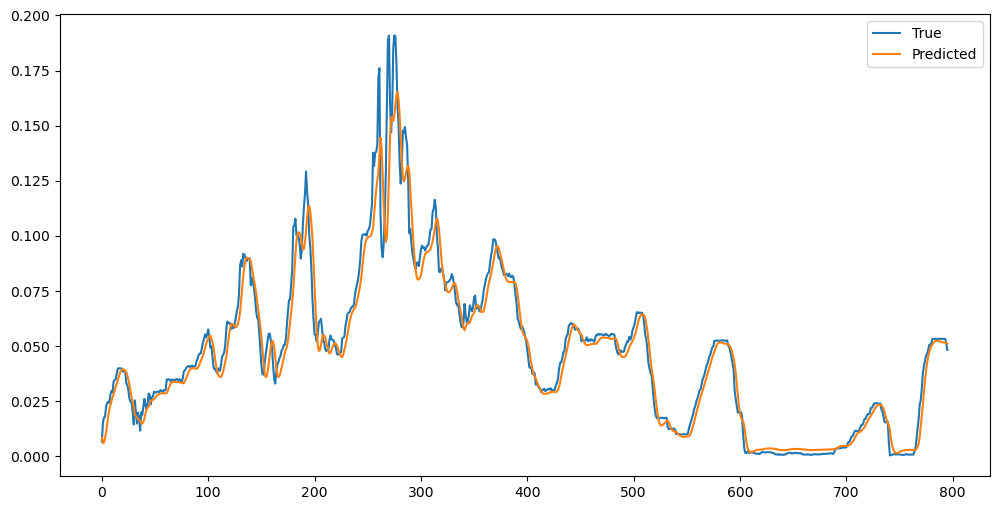

In [31]:
# plotting both the predictions and the test data

y_pred = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(y, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


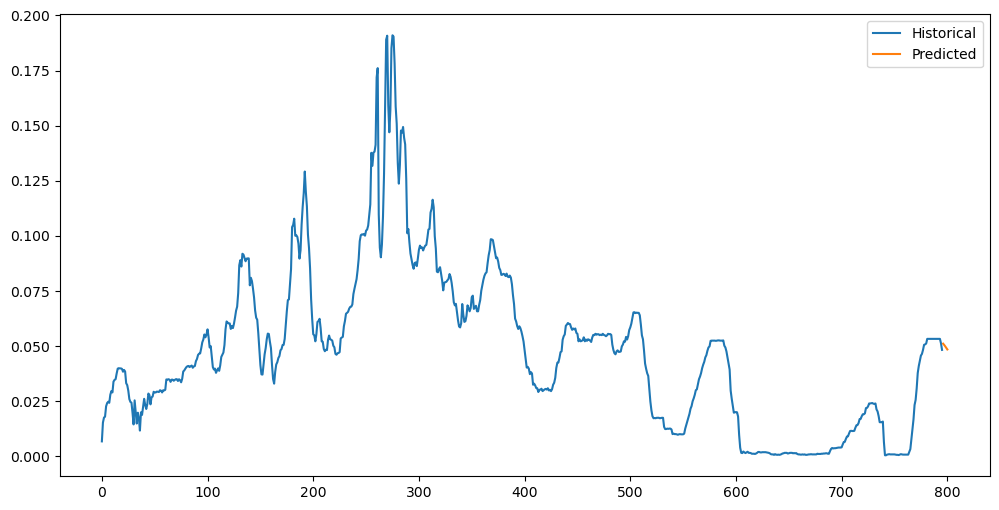

In [32]:
def predict_interest_rates(months=5):
    last_window = X[-1]
    predictions = []
    for i in range(months):
        prediction = model.predict(np.array([last_window]))
        predictions.append(prediction[0])
        last_window = np.append(last_window[1:], prediction, axis=0)
    return predictions

predictions = predict_interest_rates(5)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Historical')
plt.plot(range(len(y), len(y) + len(predictions)), predictions, label='Predicted')
plt.legend()
plt.show()

In [33]:
data.tail()

,FEDFUNDS
DATE,
2024-06-01,0.0533
2024-07-01,0.0533
2024-08-01,0.0533
2024-09-01,0.0513
2024-10-01,0.0483
